## Fit a 2D model to the gradient using FRApy


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

import numpy as np

from scipy.stats import binned_statistic

from astropy.io import fits
from astropy.wcs import WCS
from astropy import cosmology as co
import astropy.units as uu
from astropy.stats import median_absolute_deviation, sigma_clipped_stats
from astropy.convolution import convolve,Gaussian2DKernel,Moffat2DKernel
from reproject import reproject_interp

# Temporary work-around
import sys
frapy_path = '/Users/vera/Soft/MyPy/frapy/'
sys.path.append(frapy_path)
sys.path

# Import FRApy
from frapy import Observation,Metallicity_Gradient,fit_model,make_input_parameters,Output

import warnings
warnings.filterwarnings('ignore')

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

## Load data and lensing model

<IPython.core.display.Javascript object>


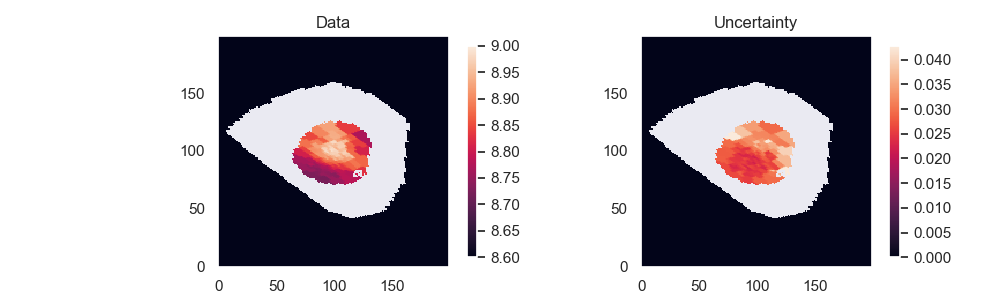

In [2]:
obs_sp = Observation(z=0.611,
                     data_path='../../Data/Lensing/AS1063/SP_Maps/SP_Map_metallicity.fits',
                     unc_path='../../Data/Lensing/AS1063/SP_Maps/SP_Map_metallicity_unc.fits',
                     seeing = 0.1)

obs_sp.plot(data_lim=(8.6,9))

Make a mask

<IPython.core.display.Javascript object>


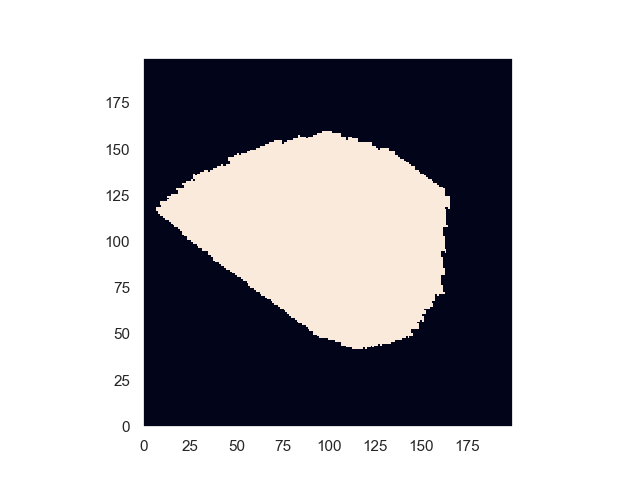

In [3]:
mask = np.ones_like(obs_sp.data)
mask[np.where(obs_sp.data==0)] = 0

plt.figure()
plt.imshow(mask,origin='lower')

Since we are fitting a map already in source plane, we use a dummy deflection map (where the deflection is zero)

In [4]:
model_sp = Metallicity_Gradient(zlens=0.348,
                                dfx_path='../../Data/Lensing/AS1063/AS1063_dpl_no_lensing.fits',
                                dfy_path='../../Data/Lensing/AS1063/AS1063_dpl_no_lensing.fits')

model_sp.create_projection_maps(obs_sp,correct_z=False)
model_sp.print_parameter_values()

cx: 0
cy: 0
q: 1.00
pa: 0.00
z_grad: -1.0000
z_0: 0.0000


## First let's fit a model with the morphological parameters (centre, q and pa) fixed to what was found with Galfit

<IPython.core.display.Javascript object>


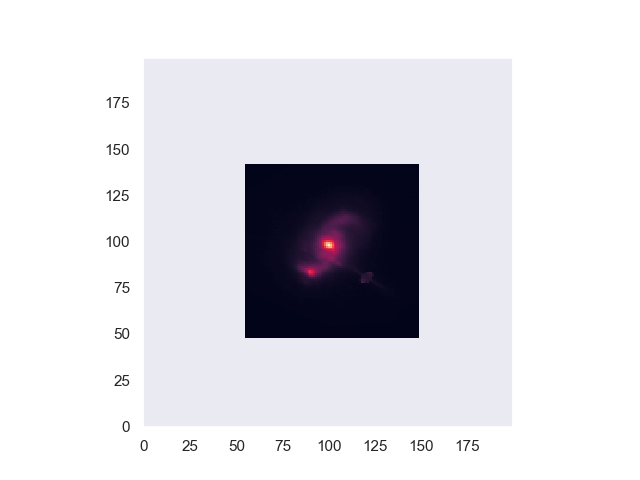

In [8]:
hst,_ = reproject_interp('../../Data/Lensing/AS1063/SP_HST/SP_AS1063_F160w.fits',obs_sp.header) 

plt.figure()
plt.imshow(hst,origin='lower')

cx: 100
cy: 98
q: 0.56
pa: -32.00
z_grad: -0.0200
z_0: 9.0000


<IPython.core.display.Javascript object>


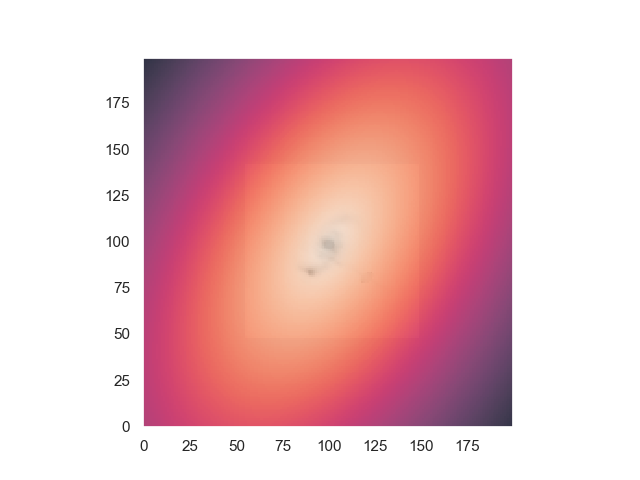

In [9]:
model_sp.cx = 100
model_sp.cy = 98
model_sp.q = 0.557 # min 0.4 max 0.9
model_sp.pa = -32 # min -10, max -80
model_sp.z_grad = -0.02
model_sp.z_0 = 9.0
model_sp.print_parameter_values()

more_sensible_model = model_sp.make_model()

plt.figure()
plt.imshow(hst,origin='lower',cmap='Greys',vmax=0.5)
plt.imshow(more_sensible_model,origin='lower',alpha=0.8)

In [10]:
model_sp.cx = 100
model_sp.cy = 98
model_sp.q = 0.557 
model_sp.pa = -32 
input_par = make_input_parameters(name    = ('z_grad', 'z_0'),
                                 value   = (-0.02, 9.0),
                                 minimum = (-0.1, 8.5),
                                 maximum = (0.0, 9.5))

In [11]:
fit  = fit_model(obs=obs_sp,
                model=model_sp,
                parameters=input_par,
                outputname='as1063_source_plane_fixed_morph',
                nsteps=5000,
                nwalkers=24,
                mask=mask )

Masking data
Using 24 walkers and fitting ['z_0', 'z_grad']:
MCMCing for 5000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 5.5469 minutes


<IPython.core.display.Javascript object>


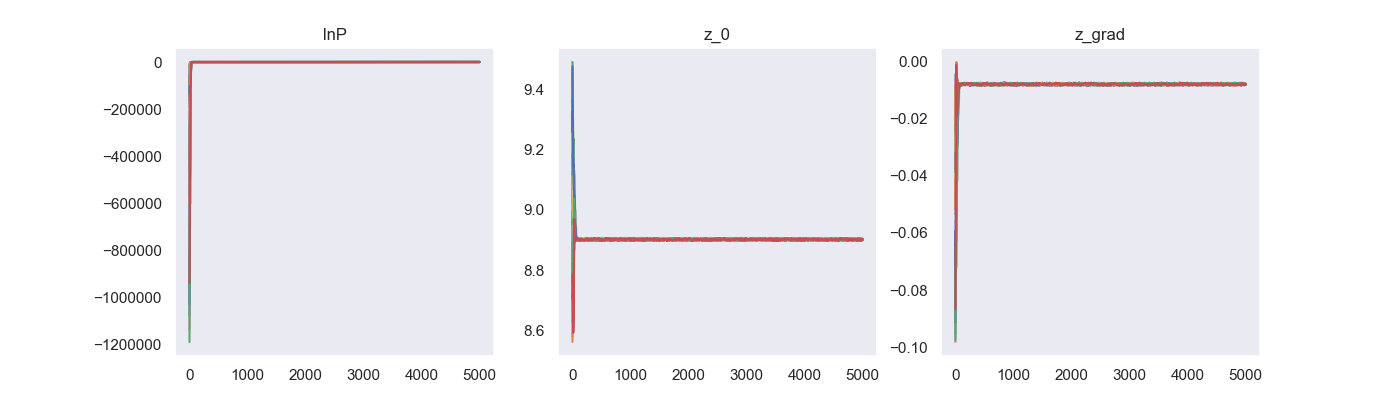

<IPython.core.display.Javascript object>


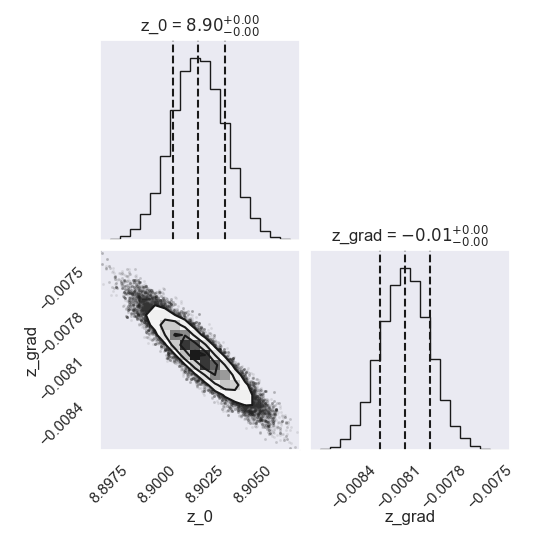

z_0 8.9021$^{+0.0014}_{-0.0014}$
z_grad -0.0081$^{+0.0002}_{-0.0002}$


In [13]:
results_fixed = Output('as1063_source_plane_fixed_morph')
results_fixed.check_convergence()
results_fixed.make_cornerplot(start=2000)
best_param_fixed = results_fixed.best_parameters(start=2000)

Masking data


<IPython.core.display.Javascript object>


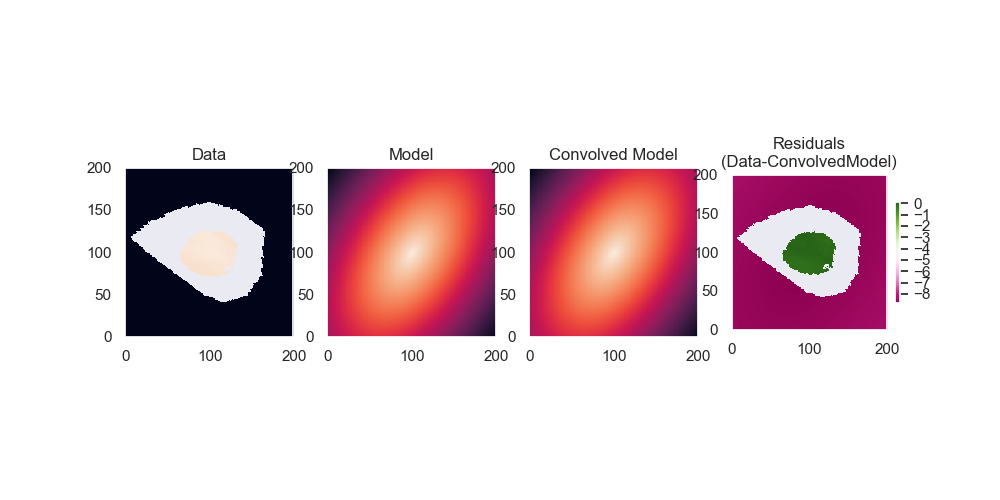

Masking data
Chi2: 14895.02
Chi2/dof: 75.23
Loglikelihood: 3782
BIC: -7553


<IPython.core.display.Javascript object>


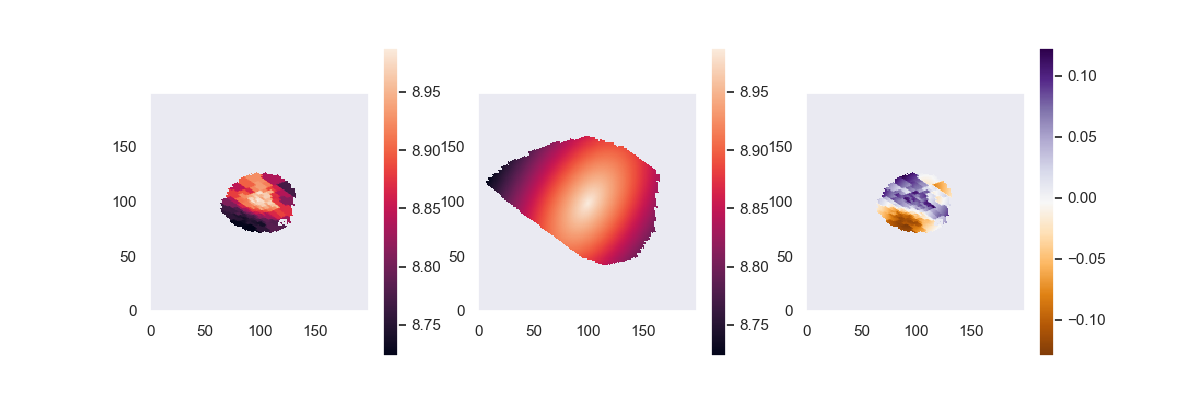

Chi2: 14895.02
Chi2/dof: 5.26


In [37]:
best_model_fixed, residuals_fixed = results_fixed.plot_solution(best_param_fixed)
chi2_dof = results_fixed.goodness_of_fit(best_param_fixed)

clean_data_sp = obs_sp.data
clean_data_sp[np.where(obs_sp.data==0)] = np.nan
clean_model_sp = best_model_fixed.data
clean_model_sp[np.where(mask == 0)] = np.nan
residuals_fixed[np.where(mask== 0)] = np.nan

fig, ax = plt.subplots(1,3,figsize=(12,4))
cax = ax[0].imshow(clean_data_sp,origin='lower')
plt.colorbar(cax,ax=ax[0])
ax[1].imshow(clean_model_sp,origin='lower')
cax = plt.colorbar(cax,ax=ax[1])
cax = ax[2].imshow(residuals_fixed,origin='lower',cmap='PuOr')
plt.colorbar(cax,ax=ax[2])


## Real chi2
free_par = 2
chi2_image = (residuals_fixed)**2/obs_sp.unc**2
chi2 = np.nansum(chi2_image[np.where(np.isfinite(chi2_image))])
print('Chi2: %0.2f'%chi2)
print('Chi2/dof: %0.2f'%(chi2/(len(np.where(np.isfinite(obs_sp.data))[0])-free_par)))

## Now we let every parameter free

Explore some initial parameters and limits

cx: 100
cy: 100
q: 0.80
pa: -60.00
z_grad: -0.0200
z_0: 9.0000


<IPython.core.display.Javascript object>


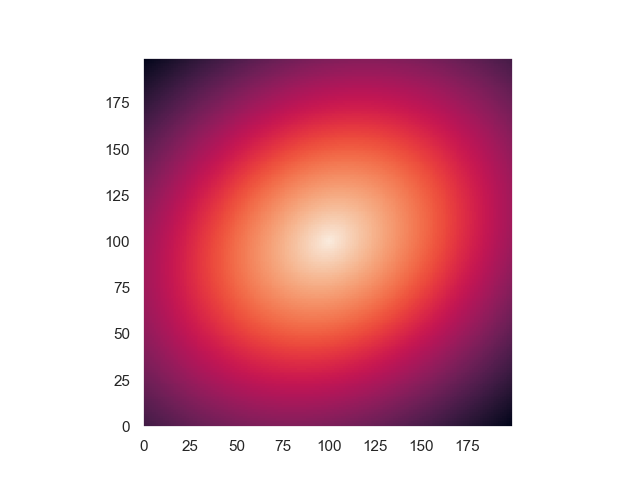

In [24]:
model_sp.cx = 100
model_sp.cy = 100
model_sp.q = 0.8
model_sp.pa = -60
model_sp.z_grad = -0.02
model_sp.z_0 = 9.0
model_sp.print_parameter_values()

more_sensible_model = model_sp.make_model()

plt.figure()
plt.imshow(more_sensible_model,origin='lower')

Convert pixel positions to arcsec 

In [19]:
from astropy.wcs import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord

wcs = WCS('../../Data/Lensing/AS1063/SP_Maps/SP_Map_metallicity.fits')

def to_hsm(x,y):
    ra,dec = wcs.all_pix2world(x,y,1)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
    print(c.to_string('hmsdms'))

to_hsm(90,90)
to_hsm(110,90)
to_hsm(99,110)
to_hsm(110,110)

#Galfit centre
print('Galfit centre',SkyCoord(ra=342.17857919*u.degree, dec=-44.53251288*u.degree).to_string('hmsdms'))

22h48m42.9018s -44d31m57.3802s
22h48m42.827s -44d31m57.3802s
22h48m42.8682s -44d31m56.5802s
22h48m42.827s -44d31m56.5802s
('Galfit centre', u'22h48m42.859s -44d31m57.0464s')


Fitting

In [41]:
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'z_grad', 'z_0'),
                                 value   = (  100,  100,  0.5,    0,    -0.02, 9.0),
                                 minimum = (   90,   90,  0.1,  -90,     -0.1, 8.5),
                                 maximum = (  110,  110,  0.9,   90,      0.0, 9.5))

In [42]:
sourceplane_fitting = fit_model(obs=obs_sp,
                                model=model_sp,
                                parameters=input_par,
                                outputname='as1063_source_plane',
                                nsteps=5000,
                                nwalkers=24,
                                mask=mask )

Masking data
Using 24 walkers and fitting ['q', 'z_grad', 'cy', 'pa', 'cx', 'z_0']:
MCMCing for 10000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 11.9872 minutes


Check fit

<IPython.core.display.Javascript object>


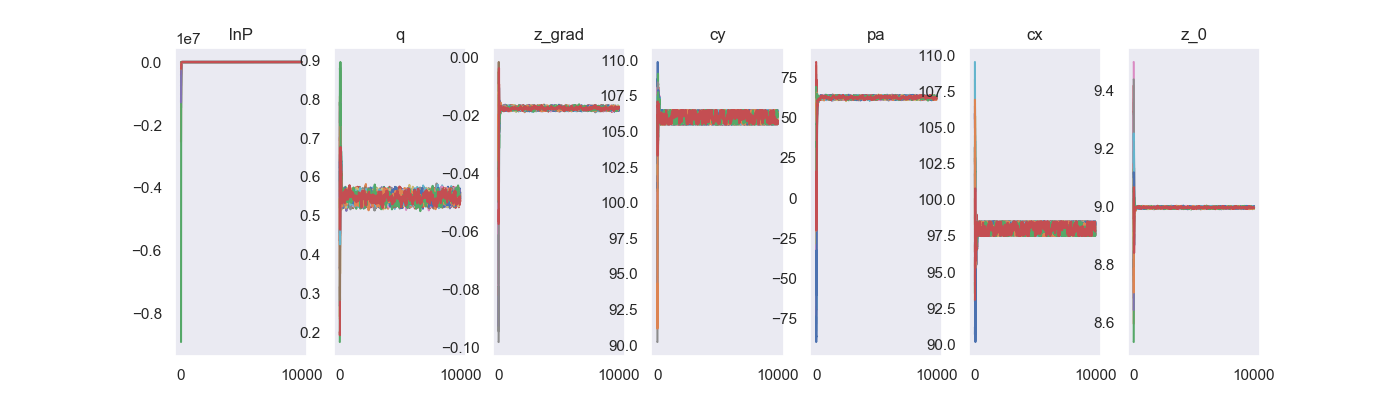

<IPython.core.display.Javascript object>


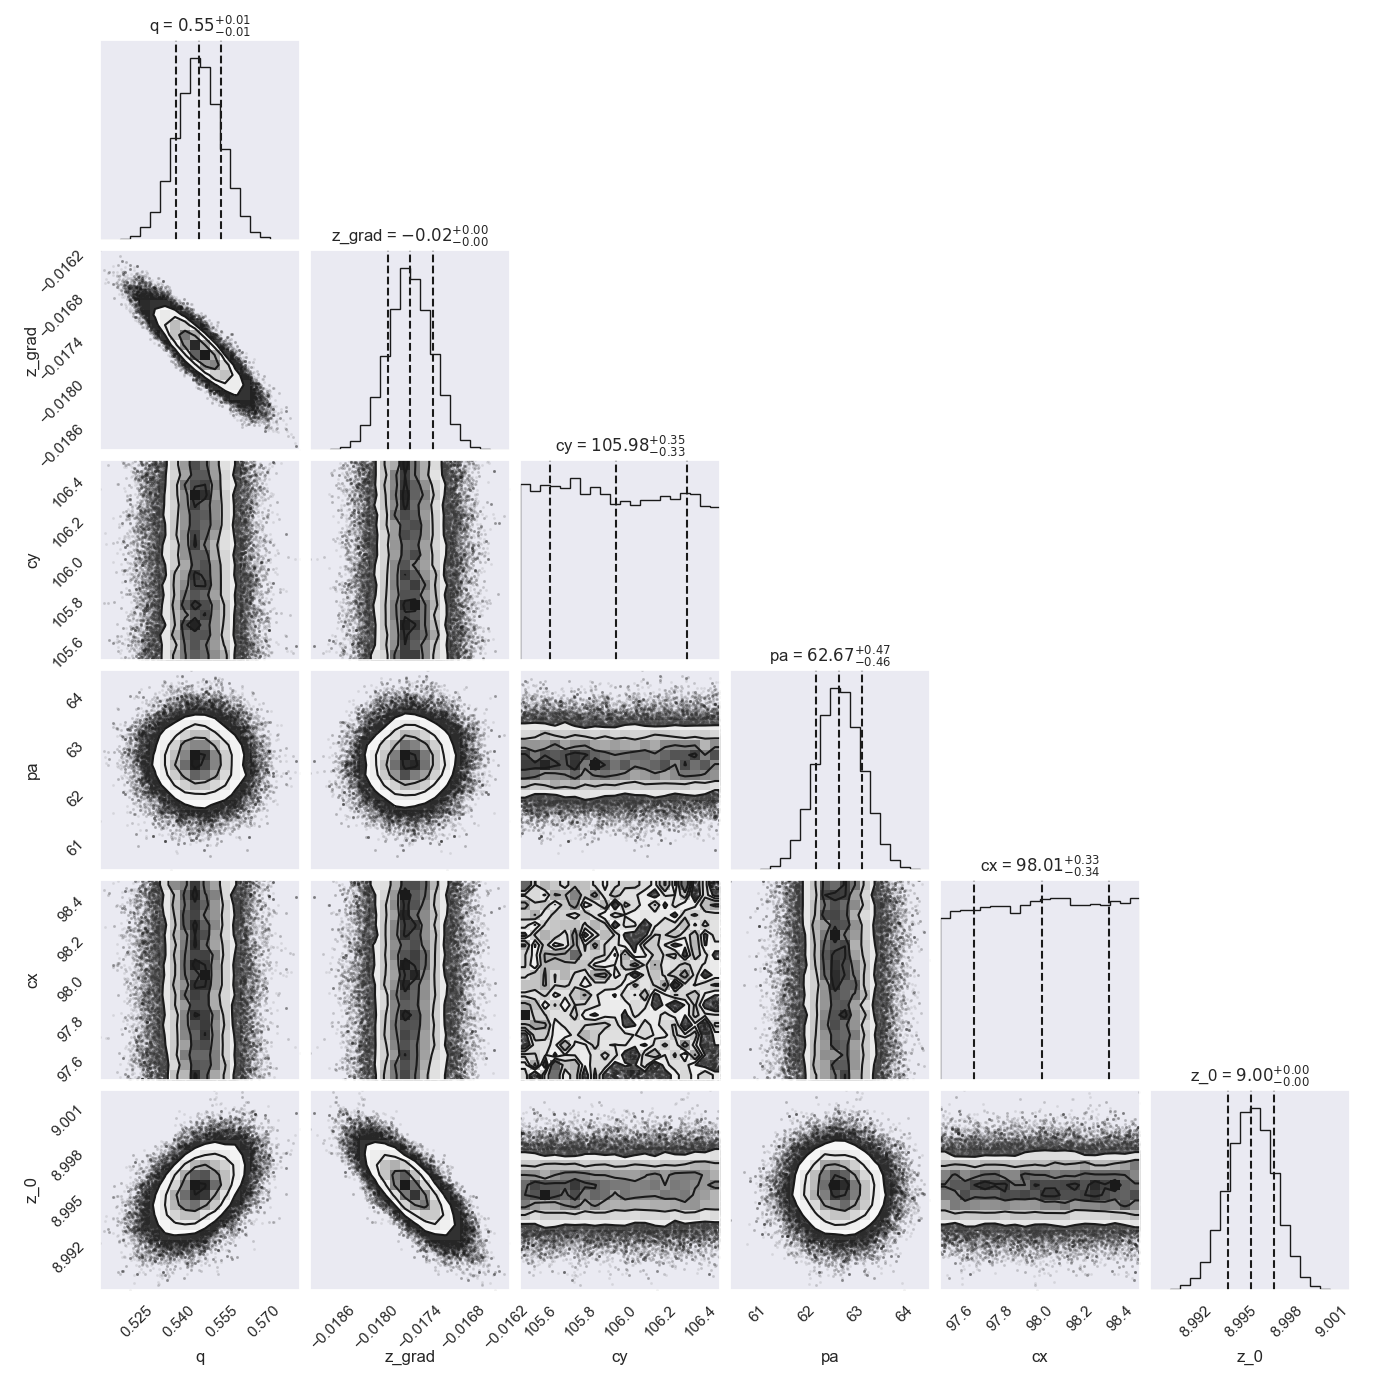

In [43]:
results_sp = Output('as1063_source_plane')
results_sp.check_convergence()
results_sp.make_cornerplot(start=2000)

In [44]:
best_param_sp = results_sp.best_parameters(start=2000)

q 0.5468$^{+0.0081}_{-0.0079}$
z_grad -0.0175$^{+0.0003}_{-0.0003}$
cy 105.9819$^{+0.3518}_{-0.3295}$
pa 62.6681$^{+0.4694}_{-0.4632}$
cx 98.0103$^{+0.3338}_{-0.3427}$
z_0 8.9957$^{+0.0015}_{-0.0015}$


Convert to sky coordinates

In [49]:
to_hsm(98,106)

22h48m42.8719s -44d31m56.7402s


Masking data


<IPython.core.display.Javascript object>


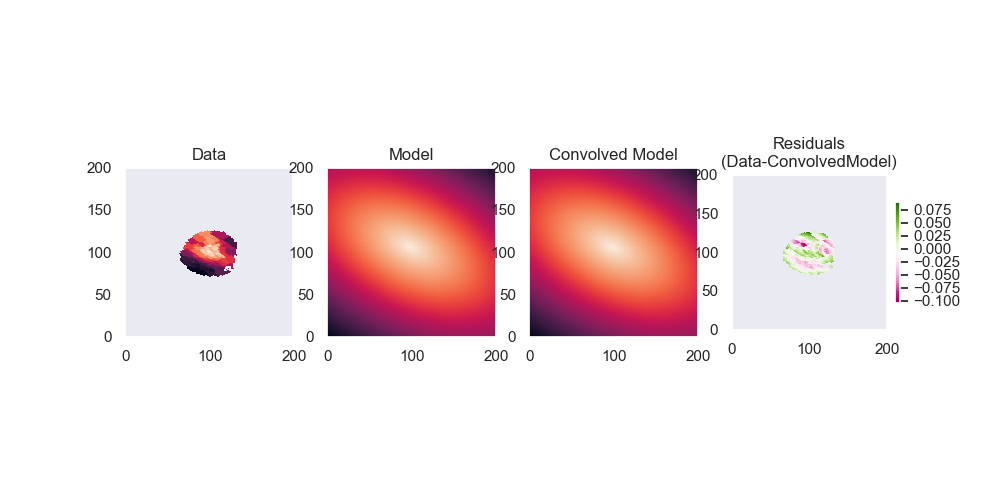

Masking data
Chi2: 2628.14
Chi2/dof: 13.55
Loglikelihood: 9915
BIC: -19799


<IPython.core.display.Javascript object>


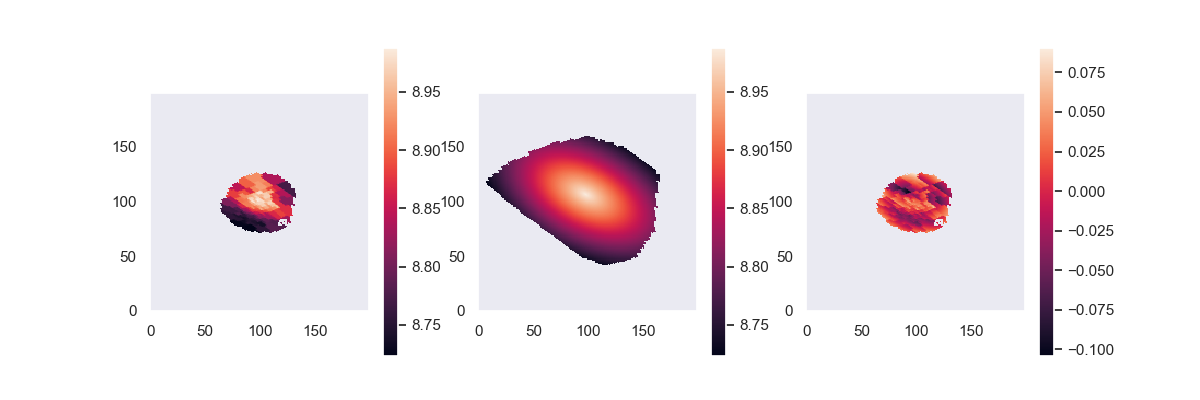

Chi2: 2628.14
Chi2/dof: 0.93


In [46]:
best_model_sp, residuals_sp = results_sp.plot_solution(best_param_sp)
chi2_dof = results_sp.goodness_of_fit(best_param_sp)

clean_data_sp = obs_sp.data
clean_data_sp[np.where(obs_sp.data==0)] = np.nan
clean_model_sp = best_model_sp.data
clean_model_sp[np.where(mask == 0)] = np.nan
residuals_sp[np.where(mask== 0)] = np.nan


fig, ax = plt.subplots(1,3,figsize=(12,4))
cax = ax[0].imshow(clean_data_sp,origin='lower')
plt.colorbar(cax,ax=ax[0])
ax[1].imshow(clean_model_sp,origin='lower')
cax = plt.colorbar(cax,ax=ax[1])
cax = ax[2].imshow(residuals_sp,origin='lower')
plt.colorbar(cax,ax=ax[2])


## Real chi2
free_par = 6
chi2_image = (residuals_sp)**2/obs_sp.unc**2
chi2 = np.nansum(chi2_image[np.where(np.isfinite(chi2_image))])
print('Chi2: %0.2f'%chi2)
print('Chi2/dof: %0.2f'%(chi2/(len(np.where(np.isfinite(obs_sp.data))[0])-free_par)))

## Same thing, but with a bit more informative priors

In [47]:
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'z_grad', 'z_0'),
                                 value   = (  100,  100,  0.5,  -30,    -0.02, 9.0),
                                 minimum = (   90,   90,  0.45,  -60,     -0.1, 8.5),
                                 maximum = (  110,  110,  0.65,   0,      0.0, 9.5))

sourceplane_fitting = fit_model(obs=obs_sp,
                                model=model_sp,
                                parameters=input_par,
                                outputname='as1063_source_plane_more_info_priors',
                                nsteps=5000,
                                nwalkers=24,
                                mask=mask )

Masking data
Using 24 walkers and fitting ['q', 'z_grad', 'cy', 'pa', 'cx', 'z_0']:
MCMCing for 5000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 3.8289 minutes


<IPython.core.display.Javascript object>


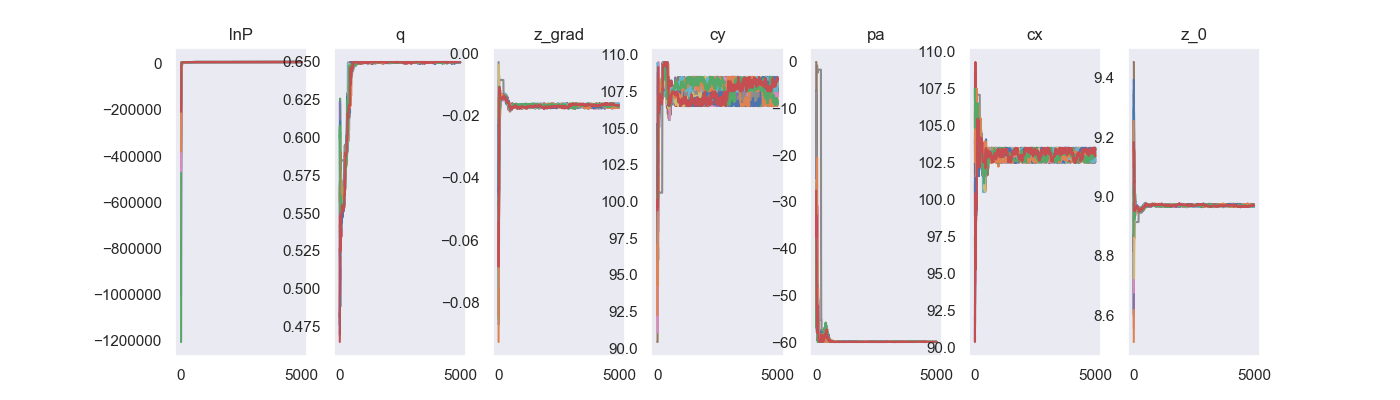

<IPython.core.display.Javascript object>


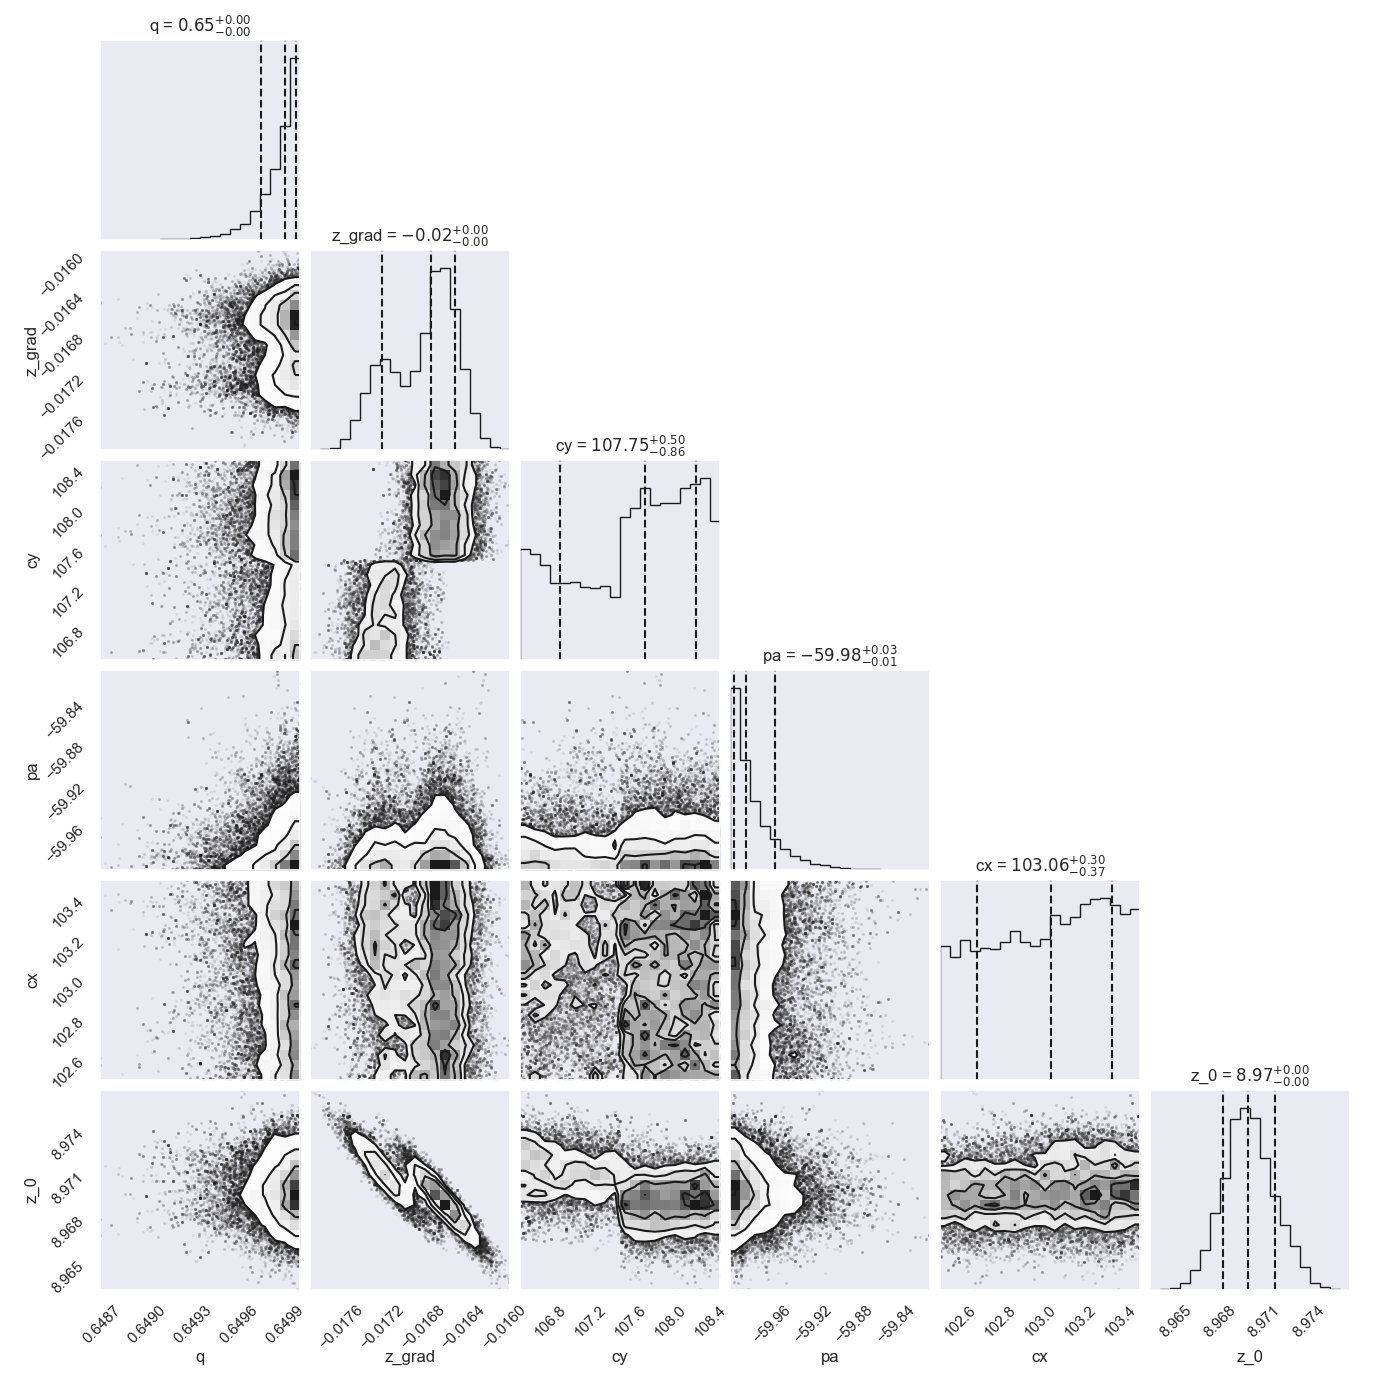

In [48]:
results_more_priors = Output('as1063_source_plane_more_info_priors')
results_more_priors.check_convergence()
results_more_priors.make_cornerplot(start=2000)

Not great

** Convert pixel to sky coordinates **

In [31]:
cy_min = 105
cy_max = 105
cx_min = 98
cx_max = 98
to_hsm(98,106)

22h48m42.8719s -44d31m56.7402s


# Summary

| Name             | dexperkpc | peakmet | cx    | cy    | q      | pa       | chi2/dof | BIC    |
|------------------|-----------|---------|-------|-------|--------|----------|----------|--------|
| source plane     | -0.0176   | 8.9956  | 98    | 106   | 0.5492 | 62.54    | 13.55    | -19798 |
| source plane HST centre| -0.0210   | 8.9595  | fixed | fixed | 0.8994 | -79.9443 | 54.27    | -11801 |
| source plane fixed morph| -0.0210   | 8.9595  | fixed | fixed | 0.8994 | -79.9443 | 13.55   | -19799 |

Compare the centres

<IPython.core.display.Javascript object>


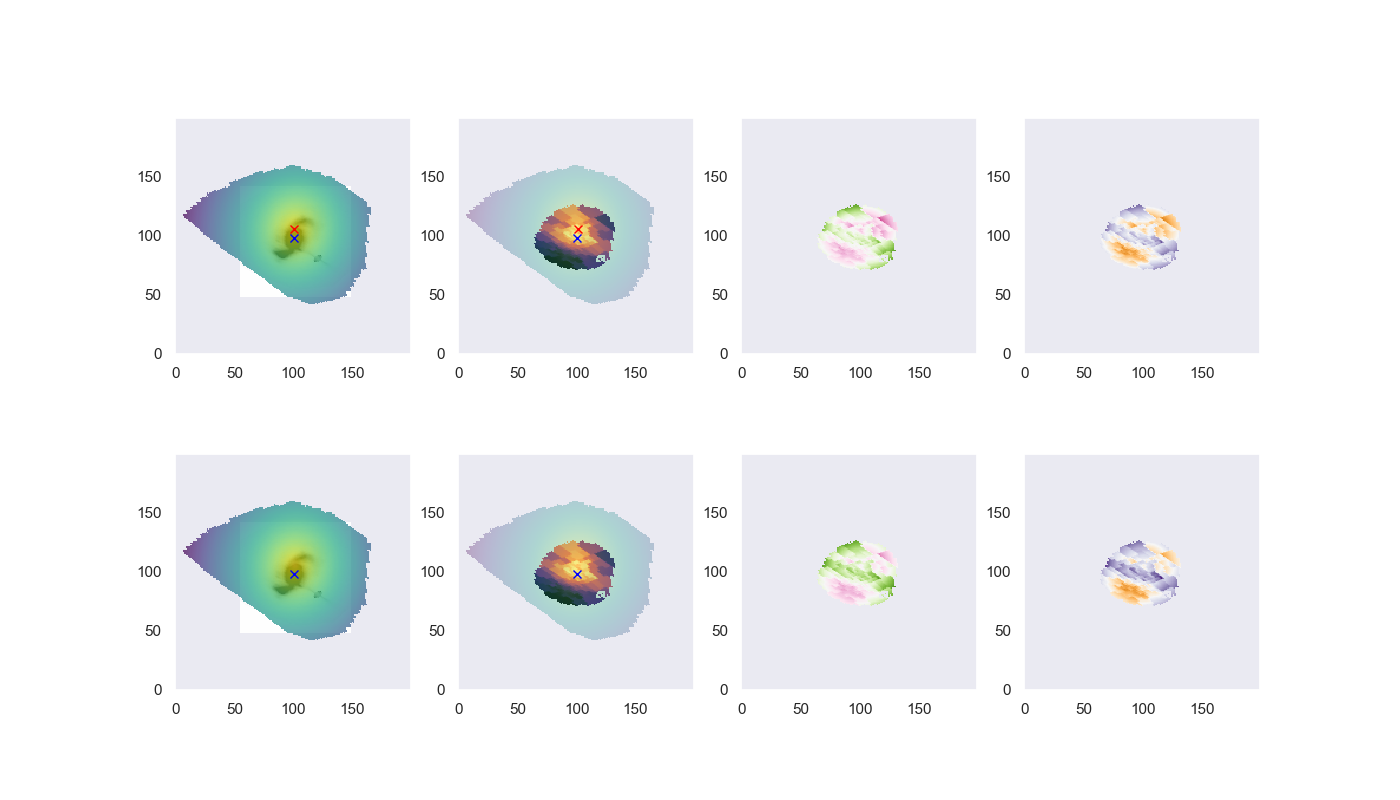

In [21]:
fig, ax = plt.subplots(2,4,figsize=(14,8))
ax = ax.ravel()


# Source plane
ax[0].imshow(hst,cmap='Greys',origin='lower',vmax=0.2)
ax[0].imshow(best_model_sp.data,cmap='viridis',origin='lower',alpha=0.7)
ax[0].plot(best_param_sp['cx']['value'],best_param_sp['cy']['value'],marker='x',color='red')
ax[0].plot(100,98,marker='x',color='blue')
ax[1].imshow(obs_sp.data,cmap='magma',origin='lower')
ax[1].imshow(best_model_sp.data,cmap='viridis',origin='lower',alpha=0.3)
ax[1].plot(best_param_sp['cx']['value'],best_param_sp['cy']['value'],marker='x',color='red')
ax[1].plot(100,98,marker='x',color='blue')
ax[2].imshow(residuals_sp,cmap='PiYG',origin='lower',vmin=-0.15,vmax=0.15)
ax[3].imshow(residuals_sp/obs_sp.unc,cmap='PuOr',origin='lower',vmin=-5,vmax=5)


# Source Plane fixed centre
ax[4].imshow(hst,cmap='Greys',origin='lower',vmax=0.2)
ax[4].imshow(best_model_sp_hst.data,cmap='viridis',origin='lower',alpha=0.7)
ax[4].plot(100,98,marker='x',color='blue')
ax[5].imshow(obs_sp.data,cmap='magma',origin='lower')
ax[5].imshow(best_model_sp_hst.data,cmap='viridis',origin='lower',alpha=0.3)
ax[5].plot(100,98,marker='x',color='blue')
ax[6].imshow(residuals_sp_hst,cmap='PiYG',origin='lower',vmin=-0.15,vmax=0.15)
ax[7].imshow(residuals_sp_hst/obs_sp.unc,cmap='PuOr',origin='lower',vmin=-5,vmax=5)

## Make 1D plot

In [22]:
def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])

def bin_data_r(data,dist):
    binned_data, bin_edges, bin_number = binned_statistic(dist,data,'mean',bins=range(0,18))
    binned_err, bin_edges, bin_number = binned_statistic(dist,data,'std',bins=range(0,18))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

def bin_data_ang(data,ang):
    binned_data, bin_edges, bin_number = binned_statistic(ang,data,'mean',bins=range(0,360,20))
    binned_err, bin_edges, bin_number = binned_statistic(ang,data,'std',bins=range(0,360,20))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

<IPython.core.display.Javascript object>


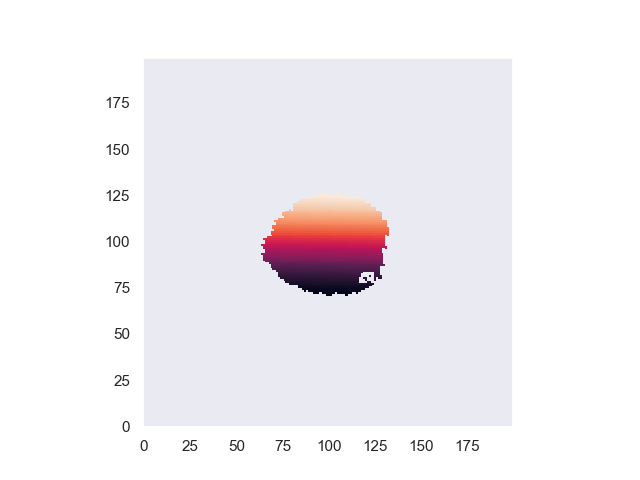

'voronoi_map[np.where(voronoi_map==-1)] = np.nan\nbins = np.unique(voronoi_map)\nbins = bins[~np.isnan(bins)]\nsize_vbin   = np.array([len(np.atleast_1d(np.where(voronoi_map==v)[0])) for v in bins ])'

In [40]:
voronoi_map = np.ones_like(obs_sp.data)
voronoi_map[np.where(np.isnan(obs_sp.data))]= np.nan

i=1
for x in range(voronoi_map.shape[0]):
    for y in range(voronoi_map.shape[1]):
        if voronoi_map[x,y] == 1:
            voronoi_map[x,y] = i
            i+=1

In [41]:
def set_figure():
    
    fig, ax = plt.subplots(3,2,figsize=(6,8))
    fig.subplots_adjust(top=0.98,left=0.13,right=0.99,wspace=0.02,hspace=0.05,bottom=0.06)
    ax = ax.ravel()
    gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[4],height_ratios=[2,1])
    gs40 = plt.Subplot(fig, gs4[0])
    fig.add_subplot(gs40)
    gs41 = plt.Subplot(fig, gs4[1])
    fig.add_subplot(gs41)
    ax[4].axis('off')
    gs5 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[5],height_ratios=[2,1])
    gs50 = plt.Subplot(fig, gs5[0])
    fig.add_subplot(gs50)
    gs51 = plt.Subplot(fig, gs5[1])
    fig.add_subplot(gs51)
    ax[5].axis('off')
    return fig,ax,gs40,gs41,gs50,gs51

def set_axis(ax,gs40,gs41,gs50,gs51):
    
    ax[0].set_ylim(8.65,9.07)
    ax[2].set_ylim(8.65,9.07)
    gs40.set_ylim(8.65,9.07)
    ax[1].set_ylim(8.65,9.07)
    ax[3].set_ylim(8.65,9.07)
    gs50.set_ylim(8.65,9.07)
    gs41.set_ylim(-0.1,0.1)
    gs51.set_ylim(-0.1,0.1)
    ax[0].set_xlim(-1,18)
    ax[2].set_xlim(-1,18)
    gs40.set_xlim(-1,18)
    gs41.set_xlim(-1,18)
    ax[1].set_xlim(-20,390)
    ax[3].set_xlim(-20,390)
    gs50.set_xlim(-20,390)
    gs51.set_xlim(-20,390)

    ax[0].set_ylabel('Data\n12 + log(O/H)')
    ax[2].set_ylabel('Model\n12 + log(O/H)')
    gs40.set_ylabel('12 + log(O/H)')
    gs41.set_ylabel('$\Delta$')

    gs41.set_xlabel('Radius (kpc)')
    gs51.set_xlabel('$\Theta$ (deg)')

    ax[0].tick_params(labelbottom=False,direction='in')    
    ax[2].tick_params(labelbottom=False,direction='in')  
    ax[1].tick_params(labelbottom=False,direction='in',labelleft=False)    
    ax[3].tick_params(labelbottom=False,direction='in',labelleft=False)
    gs50.tick_params(labelbottom=False,direction='in',labelleft=False) 
    gs51.tick_params(direction='in',labelleft=False) 
    gs41.tick_params(direction='in') 
    

def plot(obs,model,res):
    
    fig,ax,gs40,gs41,gs50,gs51 = set_figure()
    set_axis(ax,gs40,gs41,gs50,gs51)
        
    # Metallicity
    met_vbin     = measure_in_vbins(obs.data,'mean')
    emet_vbin    = measure_in_vbins(obs.unc,'mean')
    met_vbin_std = measure_in_vbins(obs.data,'std') 
    met_vbin_err = np.sqrt(emet_vbin**2 + met_vbin_std**2)

    # Model
    model.conv_data
    model_vbin     = measure_in_vbins( model.conv_data,'mean')
    model_vbin_std = measure_in_vbins( model.conv_data,'std')

    # Residuals
    res_vbin = measure_in_vbins(res,'mean') 
    res_vbin = measure_in_vbins(res,'mean') 

    # Morphology
    distance_map = model.make_distance_map()
    dist_vbin     = measure_in_vbins(distance_map,'mean')
    dist_vbin_std = measure_in_vbins(distance_map,'std')
    angular_map = model.make_azimuthal_map()
    ang_vbin     = measure_in_vbins(angular_map,'mean')
    ang_std_vbin = measure_in_vbins(angular_map,'std')

    # Radial
    ax[0].errorbar(dist_vbin, met_vbin, xerr=dist_vbin_std, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
    ax[0].scatter(dist_vbin, met_vbin, linewidths=None, alpha=0.95, marker='.', cmap='viridis', c=ang_vbin, s=size_vbin**2+35,zorder=10)
    ax[2].scatter(dist_vbin, model_vbin, linewidths=None, alpha=0.95, marker='s', cmap='viridis', c=ang_vbin, s=size_vbin**1.3+10)

    # Azimuthal
    ax[1].errorbar(ang_vbin,met_vbin,xerr=ang_std_vbin,yerr=met_vbin_err,linestyle='',ecolor='0.6',elinewidth=0.4)
    ax[1].scatter(ang_vbin,met_vbin,linewidths=None,alpha=0.95,marker='.',cmap='viridis',c=ang_vbin,s=size_vbin**2+35,zorder=10)
    ax[3].scatter(ang_vbin,model_vbin,linewidths=None,alpha=0.95,marker='s',cmap='viridis',c=ang_vbin,s=size_vbin**1.3+10)

    # Radial residuals
    met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin,dist_vbin)
    model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_vbin,dist_vbin)
    res_rbin = met_rbin - model_rbin
    gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
    gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Binned Model')
    gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
    gs40.legend(fontsize=9)

   
    ## Azimuthal Residuals 
    met_abin, met_std_abin, ang_abin = bin_data_ang(met_vbin,ang_vbin)
    model_abin, model_std_abin, ang_abin = bin_data_ang(model_vbin,ang_vbin)
    res_abin = met_abin - model_abin
    gs50.errorbar(ang_abin, met_abin, yerr=met_std_abin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Data')
    gs50.errorbar(ang_abin, model_abin, yerr=model_std_abin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Model')
    gs51.scatter(ang_abin, res_abin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')

    return fig

<IPython.core.display.Javascript object>


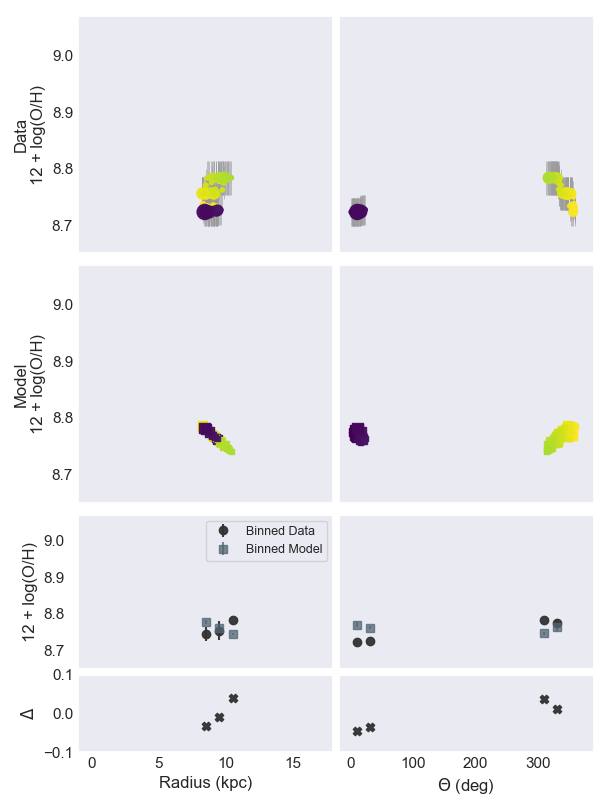

In [42]:
fig = plot(obs_sp,best_model_sp,residuals_sp)